# Machine learning training for KH
*NOTE* You need to set the environment variable "AIRFOILS_DLMC_KH_DATAPATH" to the folder containing "kh_1.nc" and "qmc_points.txt"

In [1]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import sys
import time
sys.path.append('../python')
from machine_learning import *
import os



Using TensorFlow backend.


# Setup


In [2]:
input_size=40
train_size=128
validation_size=128

data_path=os.path.join(os.environ['AIRFOILS_DLMC_KH_DATAPATH'], 'kh_1.nc')
kh_network = [20, 22, 20, 22, 20, 20, 1]

# Functionals


In [3]:

class AreaFunctional(object):
    def __init__(self, integrate_coordinate = [0.55,0.35], integrate_width=[0.25,0.25],variable='rho', 
                 short_title=None):
        self.integrate_coordinate = integrate_coordinate
        self.integrate_width = integrate_width
        
        self.variable = variable
        self.first = 10
        
        if short_title is None:
            self.__short_title = self.title()
        else:
            self.__short_title = short_title
        
    def short_title(self):
        return self.__short_title
        
    def title(self):
        return 'integrated area: $[%.2f,%.2f]\\times [%.2f,%.2f]$'% (self.integrate_coordinate[0],
                                                            self.integrate_coordinate[0]+self.integrate_width[0],
                                                            self.integrate_coordinate[1],
                                                            self.integrate_coordinate[1]+self.integrate_width[1])
    def area(self, I):
        
        return 1*(I[1][0]-I[0][0])*(I[1][1]-I[0][1])
    def __call__(self, rho):
        N = rho.shape[0]
        
        integrate_area = [[int(N*self.integrate_coordinate[0]), int(N*self.integrate_coordinate[1])],
                          [int(N*self.integrate_coordinate[0]+N*self.integrate_width[0]), 
                           int(N*self.integrate_coordinate[1]+N*self.integrate_width[1])]]
        
        g = sum(rho[integrate_area[0][0]:integrate_area[1][0], integrate_area[0][1]:integrate_area[1][1]])/self.area(integrate_area)
        
      
        return g
    
    def plot(self, d):
        N = d.shape[0]
        x, y= mgrid[0:1:N*1j,0:1:N*1j]
        plt.pcolormesh(x,y,d)
        rect = matplotlib.patches.Rectangle((self.integrate_coordinate[0],self.integrate_coordinate[1]),
                                     self.integrate_width[0],
                                     self.integrate_width[1],
                                     linewidth=1,edgecolor='r',facecolor='none')
        
        axes = plt.gca()
        axes.add_patch(rect)
        
        
        
class SinglePointFunctional(object):
    def __init__(self, coordinate = [0.55,0.35], variable='rho'):
        self.coordinate = coordinate
        
        self.variable = variable
        self.first = 10
         
    def short_title(self):
        return '$(%f,%f)$'% (self.coordinate[0], self.coordinate[1])
    def title(self):
        return 'specific point  $(%f,%f)$'% (self.coordinate[0], self.coordinate[1])

    def __call__(self, rho):
        N = rho.shape[0]
        
        x = int(N*self.coordinate[0])
        y = int(N*self.coordinate[1])
        
        return rho[x,y]
    
    def plot(self, d):
        N = d.shape[0]
        x, y= mgrid[0:1:N*1j,0:1:N*1j]
        plt.pcolormesh(x,y,d)
        rect = matplotlib.patches.Rectangle((self.coordinate[0],self.coordinate[1]),
                                     0.05,
                                     0.05,
                                     linewidth=1,edgecolor='r',facecolor='r')
        
        axes = plt.gca()
        axes.add_patch(rect)
        
    
    

In [4]:
def get_samples(data_path, functional):
    samples = []
    
    with netCDF4.Dataset(data_path) as f:
        for k in f.variables.keys():
            if functional.variable in k:
                sys.stdout.write("%d\r" % len(samples))
                sys.stdout.flush()
                samples.append(functional(f.variables[k][:,:,0]))
                
               
    print()
    return array(samples,dtype=float64)
def draw_functional(data_path, functional):
    with netCDF4.Dataset(data_path) as f:
        d = f.variables['sample_10_%s' % functional.variable][:,:,0]
        functional.plot(d)
        

                

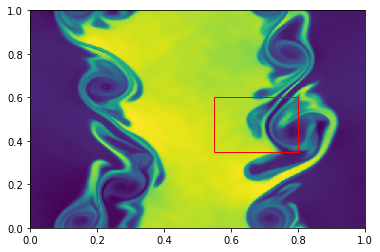

In [5]:
draw_functional(data_path, AreaFunctional())

# Basic IO

In [6]:
def get_kh_network_interpolate_qmc(data_path, functional, network_information,
                                output_information):
    console_log("Doing next configuration")
    draw_functional(data_path, functional)
    showAndSave('functional_plot')
    network, data, parameters =\
        get_kh_network_from_functional_qmc(data_path, functional, network_information,
        output_information)

    return network, data, parameters


def get_kh_network_from_functional(data_path, functional, parameters,
                                   network_information, output_information):
    start_reading_samples = time.time()
    samples = get_samples(data_path, functional)
    end_reading_samples = time.time()
    print("Reading all samples took {} seconds".format(end_reading_samples-start_reading_samples))

    return get_network_and_postprocess(parameters, samples, network_information=network_information,
        output_information=output_information)
def get_kh_network_from_functional_qmc(data_path,
    functional,
    network_information,
    output_information):
    parameter_path = os.path.join(os.path.dirname(data_path), 'qmc_points.txt')
    parameters = loadtxt(parameter_path)

    return get_kh_network_from_functional(data_path, functional, parameters,
        network_information, output_information)


# Experiments

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


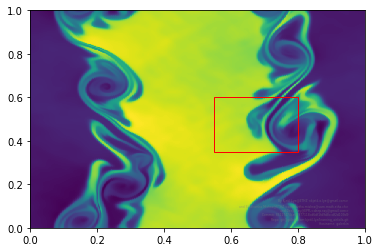

8191
Reading all samples took 10.276551723480225 seconds

Training took 1014.5878653526306 seconds


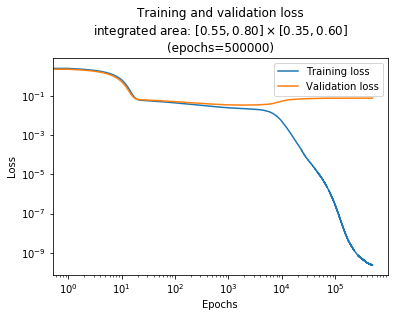


Training took 1085.7616567611694 seconds


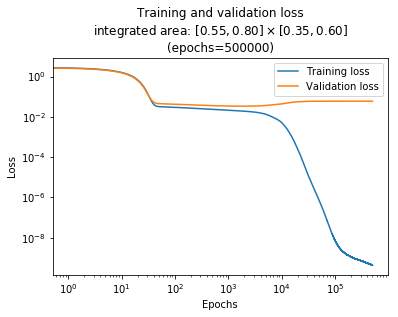


Training took 1061.1930265426636 seconds


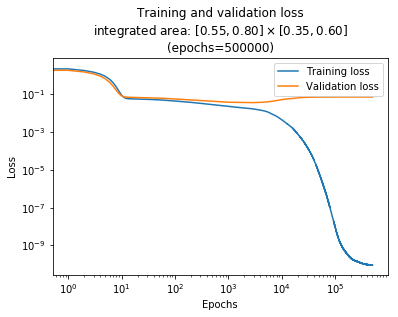

In [ ]:
variables = ['rho']

points = [[0.55,0.35], [0.75,0.75]]
func_names=["$Q_2$", "$Q_1$"]

epochs = [500000, 5000]
seed_random_number(random_seed)
optimizers = {'SGD': keras.optimizers.SGD,
             'Adam' : keras.optimizers.Adam}
for optimizer in optimizers.keys():
    display(HTML("<h1>%s</h1>" % optimizer))
    for v in variables:
        for epoch in epochs:
            tables = Tables.make_default()
    
    
           
            for (func_name, p) in zip(func_names, points):
            
                network_information = NetworkInformation(optimizer=optimizers[optimizer], epochs=epoch, 
                                                 network=kh_network, train_size=train_size,
                                                 validation_size=validation_size)
        
                functional =  AreaFunctional(integrate_coordinate=p,
                                            variable=v,
                                            short_title=func_name)
                output_information = OutputInformation(tables=tables, title=functional.title(),
                                              short_title=functional.short_title())
                
                prefix = '%s_%f_%f' % (v, p[0], p[1])
                prefix = prefix.replace('.','_')
                showAndSave.prefix = 'kh_%s_%d_%s' % (optimizer, epoch, prefix)
    
                network, data, parameters = get_kh_network_interpolate_qmc(data_path, 
                                                                        functional,
                                                                        network_information,
                                                                        output_information)
            showAndSave.prefix = 'kh_all_%s_%d_%s' % (optimizer, epoch, v)
            tables.print_tables()